In [174]:
import pandas as pd
import seaborn as sns
# from google.colab import files
import io
import glob


In [175]:
# df_main_ar = [pd.read_csv(io.BytesIO(uploaded[d])) for d in uploaded]
path = r'./data' # use your path
all_files = glob.glob(path + "/*.csv")

li = {}
li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    name = filename.split("/")[2][7:-4]
    # li[name] = (df)
    li.append(df)

AddressCount = pd.read_csv("./data/export-AddressCount.csv", index_col=None, header=0)
DAU = pd.read_csv("./data/export-DailyActiveEthAddress.csv", index_col=None, header=0)
MarCap = pd.read_csv("./data/export-MarketCap.csv", index_col=None, header=0)
NetHash = pd.read_csv("./data/export-NetworkHash.csv", index_col=None, header=0)
DailyTx = pd.read_csv("./data/export-TxGrowth.csv", index_col=None, header=0)
Fees = pd.read_csv("./data/export-TransactionFee.csv", index_col=None, header=0)
AVGFee = pd.read_csv("./data/export-AverageDailyTransactionFee.csv", index_col=None, header=0)

AddressCount = AddressCount.rename(columns={"Value":"AddressCount"})
NetHash = NetHash.rename(columns={"Value":"NetHash"})
DailyTx = DailyTx.rename(columns={"Value":"DailyTx"})
Fees = Fees.rename(columns={"Value":"Fees"})

DAU.drop('Date(UTC)',axis = 1, inplace = True)
AVGFee.drop('Date(UTC)',axis = 1, inplace = True)
AVGFee.drop('UnixTimeStamp',axis = 1, inplace = True)
AVGFee.drop('DateTime',axis = 1, inplace = True)

frame = pd.concat([AddressCount, DAU,MarCap, NetHash, DailyTx, AVGFee], axis=1)
# frame.rename(columns={frame.columns[3]:'Drop'}, inplace=True)
frame = frame.T.drop_duplicates().T

frame['Date(UTC)'] = frame['Date(UTC)'].apply(pd.to_datetime)
frame['newAddressCount'] = frame['AddressCount'].diff()

# frame.drop('Drop',axis = 1, inplace = True)
frame
# frame = pd.concat(li, axis=1)
# # frame
# frame = frame.T.drop_duplicates().T
# frame.drop(frame.columns[[7]], axis = 1, inplace = True)
# frame.rename(columns={frame.columns[[4]]:'DailyTx'}, inplace=True)
# # frame.AddressCount = 
# frame.AddressCount.rename(columns={frame.columns[6]:'AddressCount'})
# frame
# frame.TxGrowth.rename(columns={'Value':'DailyTx'}, inplace=True)
# frame[['MarketCap','AddressCount']]
# frame
# frame = pd.concat(li, axis=0, ignore_index=True)
# frame[10000:]
# [df_ad, df_day, df_mc, df_txg, tmp] = frame
# df_day

,Date(UTC),UnixTimeStamp,AddressCount,Unique Address Total Count,Unique Address Receive Count,Unique Address Sent Count,Supply,MarketCap,Price,NetHash,DailyTx,Average Txn Fee (USD),Average Txn Fee (Ether),newAddressCount
0,2015-07-30,1438214400,9205,8894,1,8893,72049306.59375,0.0,0.00,11.5297,8893,0.0,0,NaN
1,2015-07-31,1438300800,9361,0,0,0,72085498.3125,0.0,0.00,51.4594,0,0.0,0,156
2,2015-08-01,1438387200,9476,0,0,0,72113204.25,0.0,0.00,57.7845,0,0.0,0,115
3,2015-08-02,1438473600,9563,0,0,0,72141427.6875,0.0,0.00,67.9224,0,0.0,0,87
4,2015-08-03,1438560000,9639,0,0,0,72169404.40625,0.0,0.00,74.5737,0,0.0,0,76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2509,2022-06-12,1654992000,198481419,424933,309592,237694,121149953.40625,173731.456184,"1,434.02",1060942.6495,1021635,4.79,0,76799
2510,2022-06-13,1655078400,198566329,452643,308584,288743,121162209.59375,146499.650864,"1,209.12",1042559.2551,1109435,9.6,0,84910
2511,2022-06-14,1655164800,198650563,455396,311696,285966,121174326.34375,146250.141437,"1,206.94",1007032.974,1086757,6.62,0,84234
2512,2022-06-15,1655251200,198729526,449772,312591,273115,121186416.28125,149894.266434,"1,236.89",961544.4888,1097000,7.34,0,78963


In [176]:
frame

,Date(UTC),UnixTimeStamp,AddressCount,Unique Address Total Count,Unique Address Receive Count,Unique Address Sent Count,Supply,MarketCap,Price,NetHash,DailyTx,Average Txn Fee (USD),Average Txn Fee (Ether),newAddressCount
0,2015-07-30,1438214400,9205,8894,1,8893,72049306.59375,0.0,0.00,11.5297,8893,0.0,0,NaN
1,2015-07-31,1438300800,9361,0,0,0,72085498.3125,0.0,0.00,51.4594,0,0.0,0,156
2,2015-08-01,1438387200,9476,0,0,0,72113204.25,0.0,0.00,57.7845,0,0.0,0,115
3,2015-08-02,1438473600,9563,0,0,0,72141427.6875,0.0,0.00,67.9224,0,0.0,0,87
4,2015-08-03,1438560000,9639,0,0,0,72169404.40625,0.0,0.00,74.5737,0,0.0,0,76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2509,2022-06-12,1654992000,198481419,424933,309592,237694,121149953.40625,173731.456184,"1,434.02",1060942.6495,1021635,4.79,0,76799
2510,2022-06-13,1655078400,198566329,452643,308584,288743,121162209.59375,146499.650864,"1,209.12",1042559.2551,1109435,9.6,0,84910
2511,2022-06-14,1655164800,198650563,455396,311696,285966,121174326.34375,146250.141437,"1,206.94",1007032.974,1086757,6.62,0,84234
2512,2022-06-15,1655251200,198729526,449772,312591,273115,121186416.28125,149894.266434,"1,236.89",961544.4888,1097000,7.34,0,78963


In [177]:

tmp = frame.copy().loc[:, frame.columns!='Date(UTC)']
tmp = tmp.loc[:, tmp.columns!='Price'].astype(float)
tmp.corr()['MarketCap']

UnixTimeStamp                   0.714379
AddressCount                    0.807773
Unique Address Total Count      0.749642
Unique Address Receive Count    0.742365
Unique Address Sent Count       0.693195
Supply                          0.635884
MarketCap                       1.000000
NetHash                         0.898779
DailyTx                         0.704976
Average Txn Fee (USD)           0.838477
Average Txn Fee (Ether)              NaN
newAddressCount                 0.453932
Name: MarketCap, dtype: float64

In [216]:
def shift_(cur, c, n):
    if (n>0):
        df = cur.copy()
        df[c] = df[c].shift(n)
        return df[n:]
    elif(n<0):
        df = cur.copy()
        df[c] = df[c].shift(n)
        return df[:n]
    else:
        return cur.copy()

In [206]:
#Test shift
shift_(tmp,'MarketCap', -2)

,UnixTimeStamp,AddressCount,Unique Address Total Count,Unique Address Receive Count,Unique Address Sent Count,Supply,MarketCap,NetHash,DailyTx,Average Txn Fee (USD),Average Txn Fee (Ether),newAddressCount
0,1.438214e+09,9205.0,8894.0,1.0,8893.0,7.204931e+07,0.000000,1.152970e+01,8893.0,0.00,0.0,NaN
1,1.438301e+09,9361.0,0.0,0.0,0.0,7.208550e+07,0.000000,5.145940e+01,0.0,0.00,0.0,156.0
2,1.438387e+09,9476.0,0.0,0.0,0.0,7.211320e+07,0.000000,5.778450e+01,0.0,0.00,0.0,115.0
3,1.438474e+09,9563.0,0.0,0.0,0.0,7.214143e+07,0.000000,6.792240e+01,0.0,0.00,0.0,87.0
4,1.438560e+09,9639.0,0.0,0.0,0.0,7.216940e+07,0.000000,7.457370e+01,0.0,0.00,0.0,76.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2507,1.654819e+09,198328057.0,453004.0,340372.0,259603.0,1.211254e+08,173731.456184,1.059067e+06,1079448.0,8.36,0.0,81125.0
2508,1.654906e+09,198404620.0,452227.0,333462.0,252434.0,1.211377e+08,146499.650864,1.062624e+06,1031618.0,5.53,0.0,76563.0
2509,1.654992e+09,198481419.0,424933.0,309592.0,237694.0,1.211500e+08,146250.141437,1.060943e+06,1021635.0,4.79,0.0,76799.0
2510,1.655078e+09,198566329.0,452643.0,308584.0,288743.0,1.211622e+08,149894.266434,1.042559e+06,1109435.0,9.60,0.0,84910.0


In [218]:
cur = tmp.corr()['MarketCap'].copy()
# frame[['Unique Address Total Count','MarketCap']]
arr = {}
for i in range(-5, 5):
    cur = pd.concat([shift_(tmp, 'MarketCap', i*2).corr()['MarketCap'],cur], axis = 1)
    index = i*2
    arr[index] = shift_(tmp, 'MarketCap', index).corr()['MarketCap']
# cur
pd.DataFrame.from_dict(arr)

,-10,-8,-6,-4,-2,0,2,4,6,8
UnixTimeStamp,0.714795,0.714711,0.714628,0.714545,0.714462,0.714379,0.714735,0.715033,0.715071,0.714908
AddressCount,0.808077,0.808011,0.807948,0.807889,0.807832,0.807773,0.808412,0.808975,0.809222,0.809219
Unique Address Total Count,0.750977,0.750777,0.751149,0.750923,0.750372,0.749642,0.747185,0.744722,0.741939,0.738628
Unique Address Receive Count,0.745523,0.744726,0.744599,0.743993,0.743170,0.742365,0.739902,0.737593,0.735296,0.732436
Unique Address Sent Count,0.694868,0.694916,0.695388,0.695034,0.694173,0.693195,0.690261,0.686580,0.682391,0.677712
Supply,0.636112,0.636065,0.636020,0.635975,0.635929,0.635884,0.636092,0.636252,0.636202,0.635990
MarketCap,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
NetHash,0.888654,0.890448,0.892441,0.894240,0.896465,0.898779,0.902489,0.905882,0.908686,0.911040
DailyTx,0.708967,0.708458,0.708152,0.707149,0.706108,0.704976,0.703065,0.700560,0.698046,0.695123
Average Txn Fee (USD),0.814219,0.820672,0.827900,0.831550,0.835964,0.838477,0.838782,0.836719,0.833216,0.829223


In [181]:
cur.loc['Unique Address Total Count']

MarketCap    0.640938
MarketCap    0.642485
MarketCap    0.643827
MarketCap    0.645007
MarketCap    0.646461
               ...   
MarketCap    0.744722
MarketCap    0.745842
MarketCap    0.747185
MarketCap    0.748568
MarketCap    0.749642
Name: Unique Address Total Count, Length: 100, dtype: float64

In [182]:
# frame['year'] = [d.year for d in frame['Date(UTC)']]
# frame['month'] = [d.month for d in frame['Date(UTC)']]
# frame['day'] = [d.day for d in frame['Date(UTC)']]
# frame_by_m = frame[frame['day'] == 1][2:]
# frame_by_m[20:22]





# # frame_ = df_day_s['Unique Address Total Count'].diff().cumsum() / df_day_s['Unique Address Total Count'].iloc[0]
# # df_day_s_n

# # df_day.dtypes

In [183]:
# print(frame.corrwith(frame['MarketCap']))


<AxesSubplot:xlabel='MarketCap', ylabel='NetHash'>

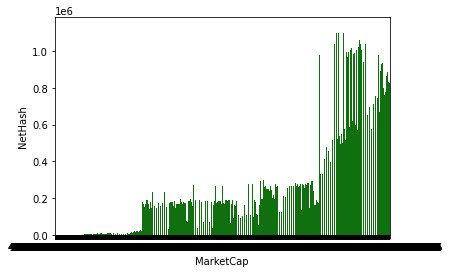

In [184]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.barplot(data = frame, x = "MarketCap", y = "NetHash", color="g")

# ax2 = plt.twinx()
# sns.lineplot(data=df_day_s_n, color="b", ax=ax2)

<AxesSubplot:xlabel='Unique Address Total Count', ylabel='MarketCap'>

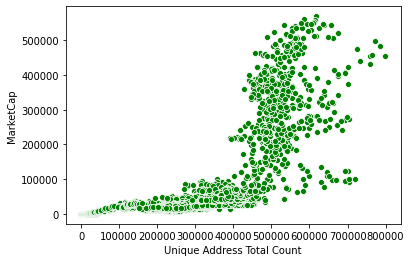

In [185]:
sns.scatterplot(data = frame, x = "Unique Address Total Count", y = "MarketCap", color="g")

<AxesSubplot:xlabel='newAddressCount', ylabel='MarketCap'>

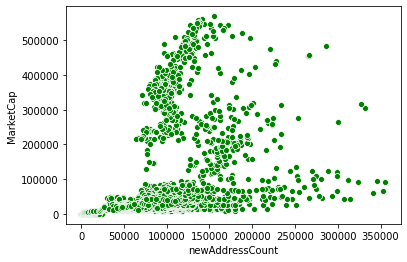

In [186]:
sns.scatterplot(data = frame, x = "newAddressCount", y = "MarketCap", color="g")

<AxesSubplot:xlabel='DailyTx', ylabel='MarketCap'>

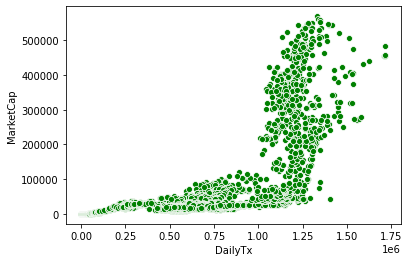

In [187]:
sns.scatterplot(data = frame, x = "DailyTx", y = "MarketCap", color="g")

In [188]:
# df_mc['Date(UTC)'] = df_mc['Date(UTC)'].apply(pd.to_datetime)
# df_mc['year'] = [d.year for d in df_mc['Date(UTC)']]
# df_mc['month'] = [d.month for d in df_mc['Date(UTC)']]
# df_mc['day'] = [d.day for d in df_mc['Date(UTC)']]
# df_mc_s = df_mc[df_mc['day'] == 1]
# df_mc_s = df_mc_s[2:]
# df_mc_s_n = df_mc_s['MarketCap'].diff().cumsum() / df_mc_s['MarketCap'].iloc[0]
# df_mc_s_n


# # df_day_s
# tmp
# df_day.dtypes

NameError: name 'df_mc' is not defined

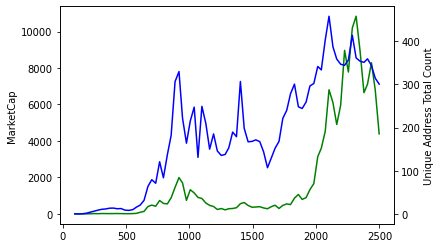

In [ ]:
# import matplotlib.pyplot as plt
# sns.lineplot(data = df_mc_s_n, color="g")
# ax2 = plt.twinx()
# sns.lineplot(data=df_day_s_n, color="b", ax=ax2)

In [ ]:
df_merged_day_mc_s_n = pd.concat([df_mc_s_n, df_day_s_n], axis = 1)

In [ ]:
df_merged_day_mc_s_n['MarketCap'].corr(df_merged_day_mc_s_n['Unique Address Total Count'])

0.7502683877968985

In [ ]:
df_day_s['squared_users'] = [d*(d-1)/2 for d in df_day_s['Unique Address Total Count']] 
# .diff().cumsum() / df_day_s['Unique Address Total Count'].iloc[0]

In [ ]:
df_day_s_n_squ = df_day_s['squared_users'].diff().cumsum() / df_day_s['squared_users'].iloc[0]

In [ ]:
df_day_s_n_squ 

63                NaN
94           1.092524
124          0.432355
155          1.544604
186          7.122598
            ...      
2378    123925.231756
2406    129704.825461
2437    118918.207560
2467     99532.088702
2498     90975.448494
Name: squared_users, Length: 81, dtype: float64

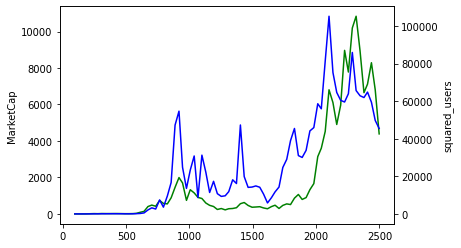

In [ ]:
sns.lineplot(data = df_mc_s_n, color="g")
ax2 = plt.twinx()
sns.lineplot(data=df_day_s_n_squ/2, color="b", ax=ax2)

In [ ]:
df_day_s_n_squ.corr(df_mc_s_n)

0.8375885631812113

In [ ]:
df_day_s_n_squ

NameError: ignored